# 4. Heatmap (countour plot) of model
This notebook focuses on visualizing the predictions of a machine learning model in the form of a heatmap, or contour plot. The objective is to create a heatmap that represents how the model's predicted probability changes across two variables: starting glucose levels and the duration of exercise. Such a visualization can provide valuable insights into how these two factors potentially influence the risk of an outcome, as predicted by the model.

Outline:

1. Load Packages and Data: In this section, we load the necessary packages and the trained models.
2. Create Meshgrid: The meshgrid is a way to generate a 2D grid of coordinates, which we use for our x (starting glucose) and y (duration of exercise) values. This allows us to evaluate the model's predictions across a grid of combinations of starting glucose levels and exercise durations.
3. Get Model Predictions: Here, we evaluate the trained models on our grid of data points, obtaining a prediction for each point.
4. Reformat Data for Contour Plot: Before plotting, we need to organize the predictions in a way that's compatible with contour plotting.
5. Plot Heatmap: Finally, we plot the heatmap (contour plot) using Matplotlib. We visualize the results both in mg/dL and mmol/L units for glucose levels, providing a comprehensive view of how the predicted probabilities vary across different starting glucose concentrations and exercise durations.

## 4.0. Load packages and data

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import pickle
import ml_helper as ml_help
import os

/home/cat/miniconda3/envs/hypo_predict_env/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/cat/miniconda3/envs/hypo_predict_env/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  d

In [3]:
def unpickle(i):
    with open(i, "rb") as fp:   
        #Unpickling 
        return pickle.load(fp)

In [4]:
directory = '../../results/models/xgb/two/'
models = []
for i in os.listdir(directory):
    models.append(unpickle(directory+i))

## 4.1. Create meshgrid

In [5]:
# 10 points between 4-14mmol/L
x1 = np.linspace(4,14,10)

# 10 points between 10-120 mins
x2 = np.linspace(10,120,10)

In [6]:
# Create lists with the meshgrid points
start_glc = []
duration = []
for i in x1:
    for j in x2:
        start_glc.append(i)
        duration.append(j)

In [7]:
# Convert to dataframe
test_df = pd.DataFrame()
test_df['Starting glucose'] = start_glc
test_df['Duration'] = duration

## 4.2. Get model predictions

In [8]:
# Empty list for predictions
predictions = []
for model in models:
    y = model.predict_proba(test_df)
    y = y[:, 1].flatten()
    predictions.append(y)

In [9]:
# Take the mean of the 10 model's predictions 
y = np.mean(predictions, axis=0)

## 4.3. Reformat data and results for contour plot

In [10]:
# Create mmol meshgrid
x1_mmol = x1
x1_grid_mmol, x2_grid_mmol = np.meshgrid(x1_mmol, x2)

# Reshape
y_grid_hypo_mmol = np.reshape(y, x1_grid_mmol.shape)

In [11]:
# Create mg meshgrid
x1_mg = x1*18
x1_grid, x2_grid = np.meshgrid(x1_mg, x2)

# Reshape
y_grid_hypo = np.reshape(y, x1_grid.shape)

## 4.4. Plot heatmap

In [12]:
# Convert to percentage risk
y_grid_hypo = y_grid_hypo*100

### 4.4.1. Twin axis with mg/dL on the bottom

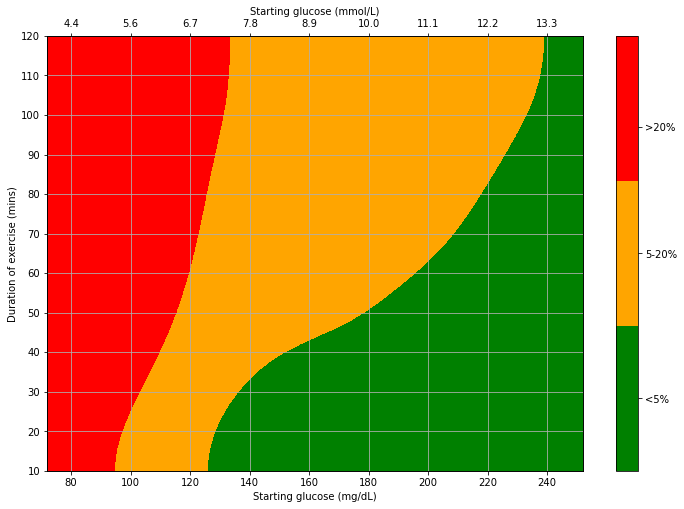

In [13]:
# Create fig with subplots
fig_hypo = plt.figure(figsize=(12, 8))

ax1 = plt.subplot()


cmap = colors.ListedColormap(['green', 'orange', 'red'])
bounds = [0, 5, 20, 100]

norm = colors.BoundaryNorm(bounds, cmap.N)

# Apply Gaussian filter to y_grid_hypo
smoothed_y_grid_hypo = gaussian_filter(y_grid_hypo.T, sigma=1)

# Replace contourf with imshow
img = ax1.imshow(smoothed_y_grid_hypo, extent=[x1_grid.min(), x1_grid.max(), x2_grid.min(), x2_grid.max()],
                origin='lower', cmap=cmap, norm=norm, aspect='auto', interpolation='bicubic', ) #

ax1.set_xlabel('Starting glucose (mg/dL)')
ax1.set_ylabel('Duration of exercise (mins)')
ax1.set_yticks(np.arange(10, 130, 10))
ax1.set_xticks(np.arange(80, 260, 20))

# Create twin x-axis at the top
ax2 = ax1.twiny()
new_tick_locations = np.arange(80, 260, 20)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels([f"{x:.1f}" for x in (new_tick_locations / 18)])#.astype(int))
ax2.set_xlabel('Starting glucose (mmol/L)')

# Add a colorbar
cbar = fig_hypo.colorbar(img, ticks=[bounds[1]/2, bounds[1]+(bounds[2]-bounds[1])/2, bounds[3]/2])  # Set the ticks manually bounds[2]/2

# Setting tick labels and colorbar description
cbar.ax.set_yticklabels([f'<{bounds[1]}%', f'{bounds[1]}-{bounds[2]}%', f'>{bounds[2]}%'])

ax1.grid()

fig_hypo.savefig('../../results/figs/fig_3.pdf')

### 4.4.2. Twin axis with mmol/L on the bottom

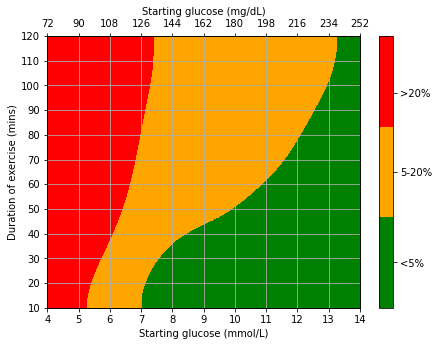

In [16]:
# Create fig with subplots
fig_hypo = plt.figure(figsize=(7, 5))

ax1 = plt.subplot()


cmap = colors.ListedColormap(['green', 'orange', 'red'])
bounds = [0, 5, 20, 100]

norm = colors.BoundaryNorm(bounds, cmap.N)

# Apply Gaussian filter to y_grid_hypo
smoothed_y_grid_hypo = gaussian_filter(y_grid_hypo.T, sigma=1)

# Replace contourf with imshow
img = ax1.imshow(smoothed_y_grid_hypo, extent=[x1_grid_mmol.min(), x1_grid_mmol.max(), x2_grid_mmol.min(), x2_grid_mmol.max()],
                 origin='lower', cmap=cmap, norm=norm, aspect='auto', interpolation='bicubic')

ax1.set_xlabel('Starting glucose (mmol/L)')
ax1.set_ylabel('Duration of exercise (mins)')
ax1.set_yticks(np.arange(10, 130, 10))
ax1.set_xticks(np.arange(4, 15, 1))

# Create twin x-axis at the top
ax2 = ax1.twiny()
new_tick_locations = np.arange(4, 15, 1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(new_tick_locations * 18)#.astype(int))
ax2.set_xlabel('Starting glucose (mg/dL)')

# Add a colorbar
cbar = fig_hypo.colorbar(img, ticks=[bounds[1]/2, bounds[1]+(bounds[2]-bounds[1])/2, bounds[3]/2])  # Set the ticks manually bounds[2]/2

# Setting tick labels and colorbar description
cbar.ax.set_yticklabels([f'<{bounds[1]}%', f'{bounds[1]}-{bounds[2]}%', f'>{bounds[2]}%'])

# Set the title for the colorbar
#cbar.set_label('Risk of hypoglycemia', rotation=270, labelpad=20)

ax1.grid()

fig_hypo.savefig('../../results/figs/fig_3.pdf')

### 4.4.3. Next to each other

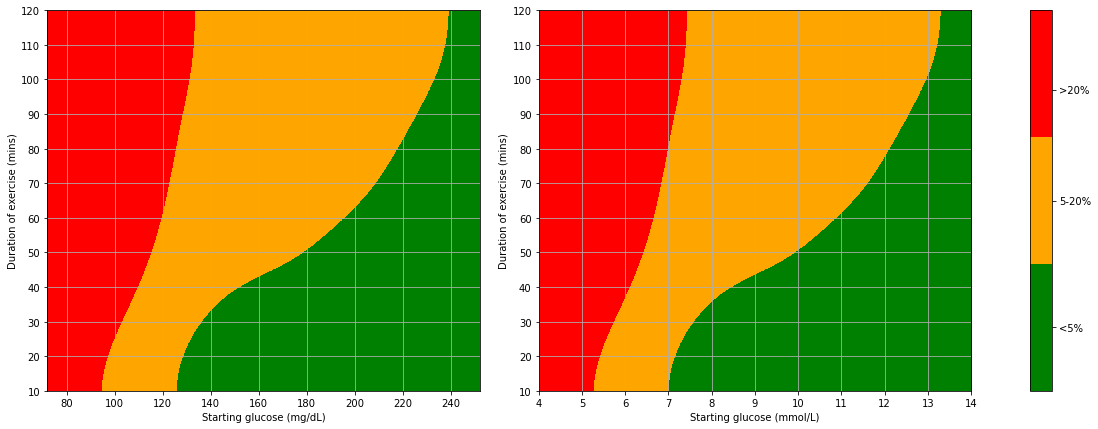

In [14]:
fig_hypo = plt.figure(figsize=(18, 7))

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
cax = plt.subplot(gs[2])

cmap = colors.ListedColormap(['green', 'orange', 'red'])
bounds = [0, 5, 20, 100]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Gaussian filter to y_grid_hypo
smoothed_y_grid_hypo = gaussian_filter(y_grid_hypo.T, sigma=1)

# Image display
img1 = ax1.imshow(smoothed_y_grid_hypo, extent=[x1_grid.min(), x1_grid.max(), x2_grid.min(), x2_grid.max()],
                 origin='lower', cmap=cmap, norm=norm, aspect='auto', interpolation='bicubic')
img2 = ax2.imshow(smoothed_y_grid_hypo, extent=[x1_grid_mmol.min(), x1_grid_mmol.max(), x2_grid_mmol.min(), x2_grid_mmol.max()],
                 origin='lower', cmap=cmap, norm=norm, aspect='auto', interpolation='bicubic')

ax1.set_xlabel('Starting glucose (mg/dL)')
ax1.set_ylabel('Duration of exercise (mins)')
ax1.set_yticks(np.arange(10, 130, 10))
ax1.set_xticks(np.arange(80, 260, 20))

ax2.set_xlabel('Starting glucose (mmol/L)')
ax2.set_ylabel('Duration of exercise (mins)')
ax2.set_yticks(np.arange(10, 130, 10))
ax2.set_xticks(np.arange(4, 15, 1))

# Add colorbar
cbar = fig_hypo.colorbar(img1, cax=cax, ticks=[bounds[1]/2, bounds[1]+(bounds[2]-bounds[1])/2, bounds[3]/2])
cbar.ax.set_yticklabels([f'<{bounds[1]}%', f'{bounds[1]}-{bounds[2]}%', f'>{bounds[2]}%'])

ax1.grid()
ax2.grid()

plt.show()
